# Electricity Dataset

https://paperswithcode.com/dataset/electricity

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

from darts.metrics import mape, mse, rmse, mae

In [5]:
def print_metrics(name, series, forecast):
  print(name + ' metrics:')
  print('MAPE = {:.2f}%'.format(mape(series, forecast)))
  print('RMSE = {:.2f}'.format(rmse(series, forecast)))
  print('MSE = {:.2f}'.format(mse(series, forecast)))
  print('MAE = {:.2f}'.format(mae(series, forecast)))
  print('')


In [6]:
def plot_forecast(series, forecast, title):
    plt.figure(figsize=(25,5))
    series.plot(label="actual")
    forecast.plot(label="forecast")
    plt.title(title)
    plt.legend()
    plt.show()


In [7]:
df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
df = df[['ds', 'Global_active_power']]

/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/ipykernel_67801/1877659380.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/ipykernel_67801/1877659380.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/ipykernel_67801/1877659380.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Ti

In [8]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

df.head(100)

,ds,Global_active_power
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666
...,...,...
95,2006-12-16 18:59:00,4.224
96,2006-12-16 19:00:00,4.070
97,2006-12-16 19:01:00,3.612
98,2006-12-16 19:02:00,3.458


In [9]:
# count NA values
df.isna().sum() / len(df)

ds                     0.000000
Global_active_power    0.012518
dtype: float64

In [10]:
# fill NA values with the previous value
df = df.ffill()

## Load time series data

In [11]:
TRAIN_DAYS = 60
PREDICTION_HOURS = 24

In [12]:
series = TimeSeries.from_dataframe(df, time_col='ds', value_cols='Global_active_power', fill_missing_dates=True, freq=None)
series = series.slice_n_points_before(series.end_time(), TRAIN_DAYS*24*60)

series = series.resample('10min', method='pad')

In [13]:
print(len(series))

8641


<Axes: xlabel='ds'>

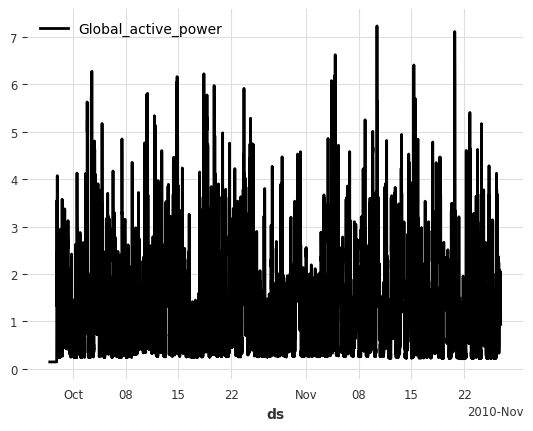

In [14]:
series.plot()

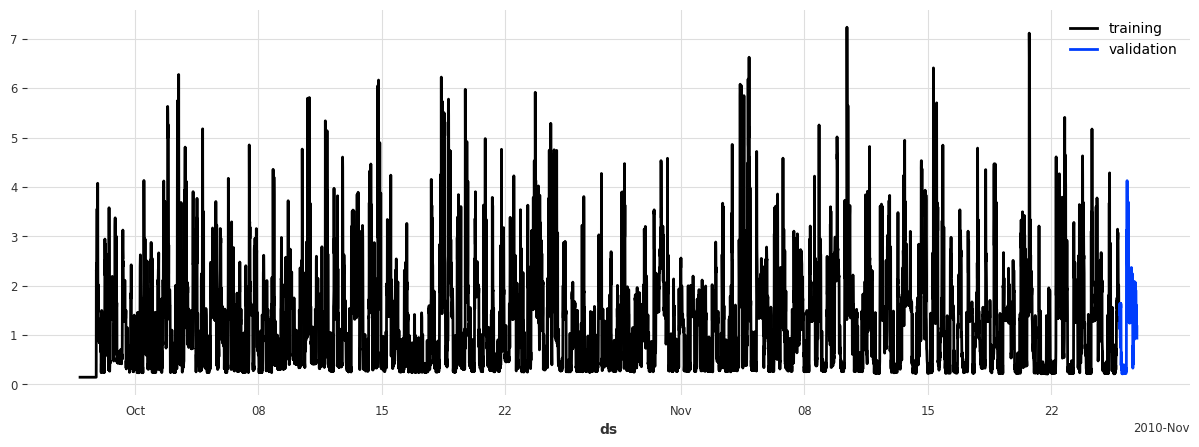

In [15]:
train, val = series.split_after((TRAIN_DAYS - 1) / TRAIN_DAYS)
plt.figure(figsize=(15, 5))
train.plot(label="training")
val.plot(label="validation")

to_predict = len(val)

## Baseline Model

/Users/kacper/private/ED/.venv/lib/python3.12/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/Users/kacper/private/ED/.venv/lib/python3.12/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


<Axes: xlabel='ds'>

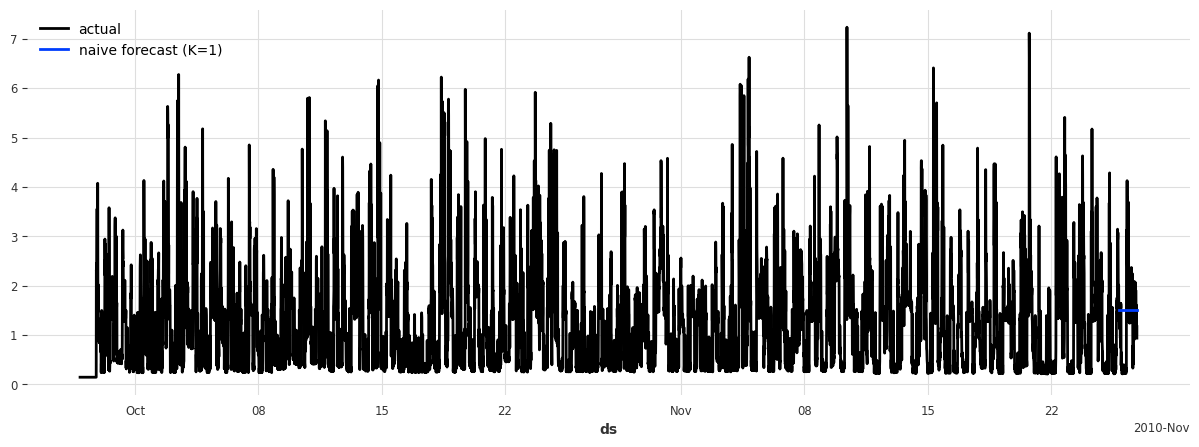

In [14]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
plt.figure(figsize=(15, 5))
naive_model.fit(train)
naive_forecast = naive_model.predict(to_predict)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

In [15]:
from darts.models.forecasting.xgboost import XGBModel

xgb_model = XGBModel(
    lags=24 * 7 * 6,
    output_chunk_length=100,
)

xgb_model.fit(train, verbose=True)

xgb_forecast = xgb_model.predict(to_predict)


In [64]:
series_after_train = series.slice_intersect(val)
plot_forecast(series, xgb_forecast, "XGBoost")
plot_forecast(series_after_train, xgb_forecast, "XGBoost")

# plot xgboost forecast with naive on the same plot not using plot_forecast
plt.figure(figsize=(25,5))
series_after_train.plot(label="actual")
xgb_forecast.plot(label="XGBoost")
naive_forecast.plot(label="Naive")
plt.title("XGBoost vs Naive")
plt.legend()
plt.show()


NameError: name 'xgb_forecast' is not defined

In [17]:
print_metrics('XGBoost', val, xgb_forecast)
print_metrics('Naive', val, naive_forecast)

XGBoost metrics:
MAPE = 68.67%
RMSE = 0.67
MSE = 0.45
MAE = 0.48

Naive metrics:
MAPE = 156.78%
RMSE = 0.90
MSE = 0.80
MAE = 0.70



# Time GPT

In [1]:
from nixtlats import TimeGPT  # Importing the TimeGPT class from nixtlats library.


In [2]:
timegpt = TimeGPT(token='weź se swój')

In [50]:
if timegpt.validate_token():
    print("Token validation successful!")  # Token is valid.
else:
    # Raise an exception if token validation fails.
    raise Exception("Token validation failed! Please check go to https://dashboard.nixtla.io/ to get your token.")


INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


Token validation successful!


In [51]:
# to pandas dataframe
train_df = train.pd_dataframe().dropna()

# make index as separate column named timestamp
train_df['timestamp'] = train_df.index

# rename column Global_active_power to value
train_df = train_df.rename(columns={'Global_active_power': 'value'})

# drop index
train_df = train_df.reset_index(drop=True)

In [55]:
train_df

component,value,timestamp
0,0.146,2010-09-27 21:10:00
1,0.146,2010-09-27 21:20:00
2,0.146,2010-09-27 21:30:00
3,0.146,2010-09-27 21:40:00
4,0.146,2010-09-27 21:50:00
...,...,...
8491,1.694,2010-11-25 20:20:00
8492,1.428,2010-11-25 20:30:00
8493,1.426,2010-11-25 20:40:00
8494,1.522,2010-11-25 20:50:00


In [70]:
timegpt_fcst_df = timegpt.forecast(df=train_df, h=len(series_after_train), time_col='timestamp', target_col='value')


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: 10min
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


In [71]:
timegpt_fcst_df.head()

,timestamp,TimeGPT
0,2010-11-25 21:10:00,1.495954
1,2010-11-25 21:20:00,1.450277
2,2010-11-25 21:30:00,1.375503
3,2010-11-25 21:40:00,1.284727
4,2010-11-25 21:50:00,1.204912


In [72]:
# convert timegpt forecast to TimeSeries
timegpt_forecast = TimeSeries.from_dataframe(timegpt_fcst_df, time_col='timestamp', value_cols='TimeGPT')

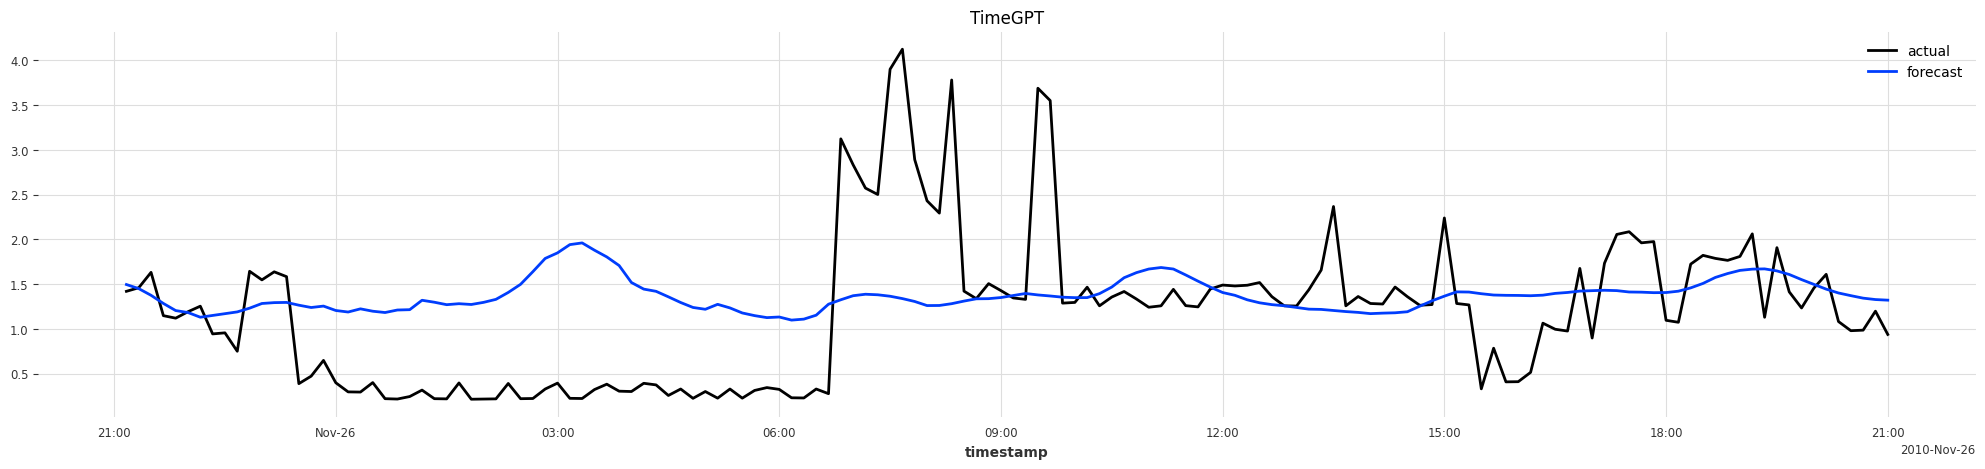

In [73]:
# plot timegpt forecast
plot_forecast(series_after_train, timegpt_forecast, "TimeGPT")

# Arima

In [19]:
print(train)

<TimeSeries (DataArray) (ds: 8497, component: 1, sample: 1)> Size: 68kB
array([[[  nan]],

       [[0.146]],

       [[0.146]],

       ...,

       [[1.426]],

       [[1.522]],

       [[1.512]]])
Coordinates:
  * ds         (ds) datetime64[ns] 68kB 2010-09-27T21:00:00 ... 2010-11-25T21...
  * component  (component) object 8B 'Global_active_power'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [18]:
# arima model
from darts.models import AutoARIMA

model = AutoARIMA(verbose=True)
model.fit(train)

prediction = model.predict(to_predict, verbose=True)

ValueError: Input y contains NaN.

<Axes: xlabel='ds'>

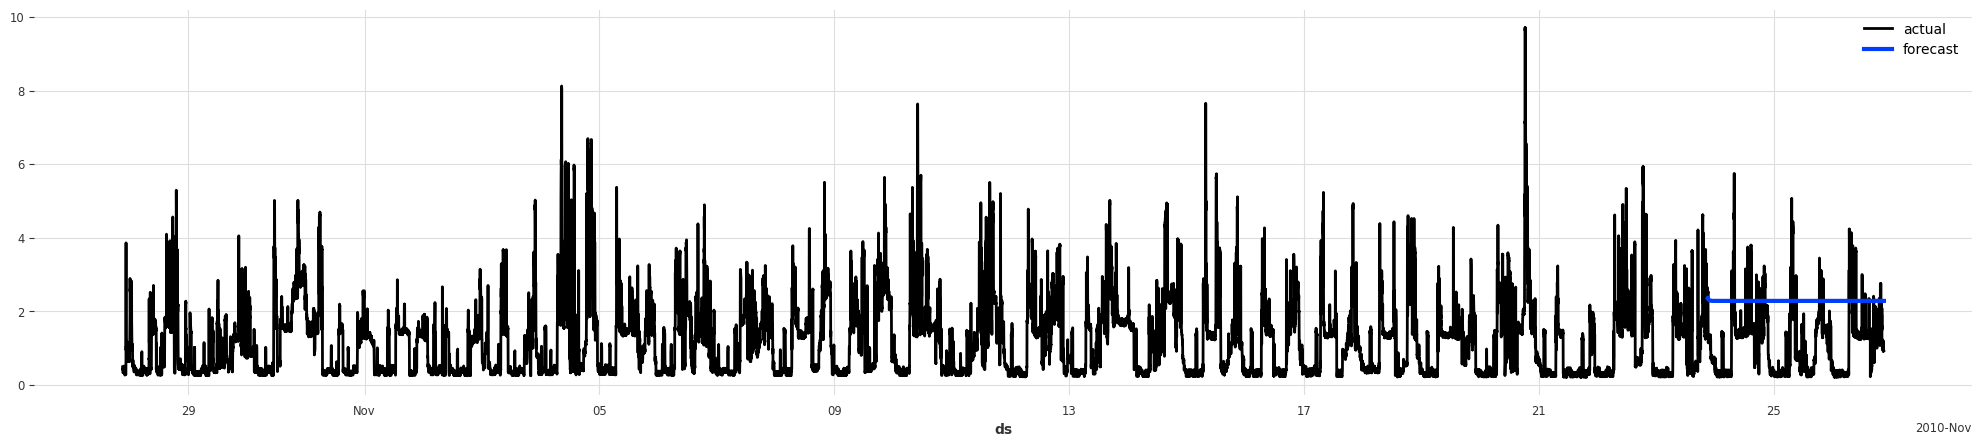

In [ ]:

plt.figure(figsize=(25,5))
series.plot(label='actual')
prediction.plot(label='forecast', lw=3)

In [ ]:
# exponential smoothing

from darts.models import ExponentialSmoothing

model_es = ExponentialSmoothing(seasonal_periods=7)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.9, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")

  0%|          | 0/1009 [00:00<?, ?it/s]

KeyboardInterrupt: 